Examine the distribution of noise in production data.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.stattools import robust_kurtosis, robust_skewness
from scipy.stats import kstest, norm, laplace, logistic, gennorm

golden_ratio = (1 + np.sqrt(5)) / 2

In [14]:
# create function to calculate modified ARPS decline
def calc_modified_arps(qi=None, di=None, b=None, dmin=None, qab=None):
        """
        Calculate a modified ARPS decline with a terminal exponential 
        decline and an abandonment rate.
        
        Parameters:
        - qi: Initial production rate, bopd
        - di: Initial decline rate, effecitve annual
        - b: b-factor
        - dmin: Minimum decline rate, effective annual
        - r_abandon: Abandonment rate, bopd
        
        Returns:
        - Production rate at time t
        """
        t = np.arange(0, 365 * 100)
        D_tangent = ((1 - di) ** (-b) - 1) / b
        D_terminal = -1 * np.log(1 - dmin)
        q_terminal = qi * (D_terminal / D_tangent) ** (1 / b)
        t_terminal = ((qi / q_terminal) ** b - 1) / (b * D_tangent / 365)

        x = np.zeros(len(t))
        mask = t < t_terminal
        x[mask] = qi * (1 + b * (D_tangent / 365) * t[mask]) ** (-1 / b)
        x[~mask] = q_terminal * np.exp(-1 * (D_terminal / 365) * (t[~mask] - t_terminal))
        x[x < qab] = 0

        return x

def calculate_variogram_for_ts(ts, n_lags=10):
        """
        Calculate the variogram for a time series.

        Parameters:
        - ts: Time series
        - n_lags: Number of lags to calculate the variogram for

        Returns:
        Vector of the semi-variance for each lag
        """
        variances = np.zeros(n_lags)
        for i in range(n_lags):
                variances[i] = 0.5 * np.mean((ts[(i+1):] - ts[:-(i+1)]) ** 2)
        return variances

In [ ]:
# load the data into a df
prod = pd.read_csv(r'DAILY_PRODUCTION.csv')
prod['D_DATE'] = pd.to_datetime(prod['D_DATE'])
prod['ON'] = np.where(prod['OIL'] > 0, 1, 0)
prod['DAYS_ON'] = prod.groupby('WELL_NAME')['ON'].cumsum()
prod = prod[prod['ON'] > 0].copy()
prod['PCT_CHANGE'] = (prod['OIL'] - prod['OIL'].shift(1)) / prod['OIL'].shift(1) * 100

In [ ]:
prod.head()

# INVESTIGATE DAILY RATE

In [ ]:
# plot the rate-time profile for each well
fig, ax = plt.subplots(figsize=(5 * golden_ratio, 5))
sns.scatterplot(x='DAYS_ON', y='OIL', hue='WELL_NAME', data=prod, ax=ax, s=3)
ax.set(yscale='log', ylim=(1,3000))
plt.show()

In [ ]:
# plot the autcorr and partial autocorr for each well
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(2 * 3 * golden_ratio, 3 * 3))
for i, well in enumerate(prod['WELL_NAME'].unique()):
    ax = axs[i, 0]
    plot_acf(prod.loc[(prod['WELL_NAME'] == well) & (prod['ON'])]['OIL'].dropna(), ax=ax, lags=50)
    ax.set(title='autocorr: ' + well)
    ax = axs[i, 1]
    plot_pacf(prod.loc[(prod['WELL_NAME'] == well) & (prod['ON'])]['OIL'].dropna(), ax=ax, lags=50)
    ax.set(title='partial autocorr: ' + well)
plt.tight_layout(); plt.show()

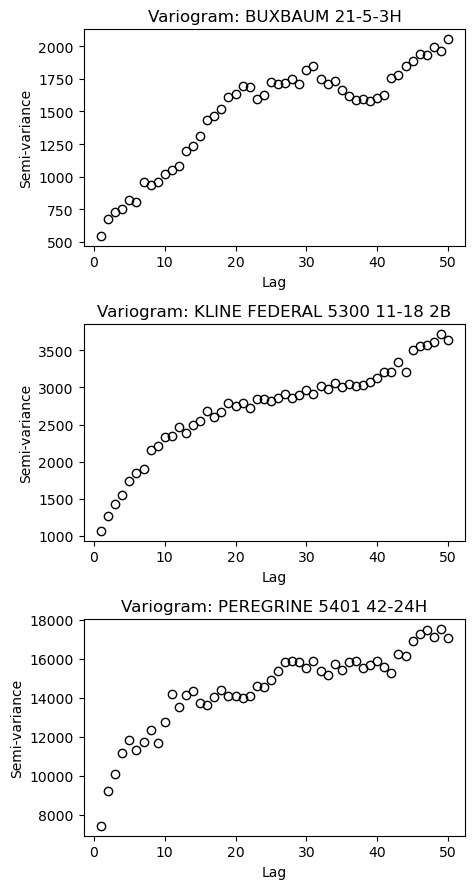

In [23]:
# plot variogram for each well
lags=50
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(3 * golden_ratio, 3 * 3))
for i, well in enumerate(prod['WELL_NAME'].unique()):
    variances = calculate_variogram_for_ts(prod.loc[(prod['WELL_NAME'] == well) & (prod['ON'])]['OIL'].dropna().values, 
                                           n_lags=lags)
    axs[i].plot(range(1, lags + 1), variances, 'o', mfc='none', mec='k')
    axs[i].set(title='Variogram: ' + well, xlabel='Lag', ylabel='Semi-variance')
plt.tight_layout(); plt.show()

In [ ]:
fig, axs = plt.subplots(nrows=3, ncols=5, figsize=(5 * 3 * golden_ratio, 3 * 3))
for i, well in enumerate(prod['WELL_NAME'].unique()):
    for j, lag in enumerate(range(1,10,2)):
        ax = axs[i, j]
        data = prod.loc[(prod['WELL_NAME'] == well) & (prod['ON'])]['OIL']
        shifted_data = data.shift(lag)
        sns.scatterplot(x=data, y=shifted_data, ax=ax, s=3)
        ax.plot([0, 1000], [0, 1000], color='black', linestyle='--')
        ax.set(xlim=(0,1000), ylim=(0,1000), title='lag: ' + str(lag))
        
    # Add well name as a label on the left side and rotate 180 degrees
    axs[i, 0].text(-0.25, 0.5, well, transform=axs[i, 0].transAxes, va='center', rotation=90)
    
plt.tight_layout(); plt.show()


There is autocorrelation in daily production data up to the 4th lag.

In [ ]:

arima_models = {}
for well in prod['WELL_NAME'].unique():
    # build ARIMA model
    arima_models[well] = ARIMA(prod.loc[(prod['WELL_NAME'] == well) & (prod['ON'])]['OIL'].values, 
                               order=(4, 0, 1), trend='t').fit()
    print(arima_models[well].summary())
    
    # Plot diagnostic
    fig, axs = plt.subplots(ncols=3,figsize=(3 * 3 * golden_ratio, 4))
    axs[0].plot(arima_models[well].resid)
    axs[0].set_title('Residuals')
    sns.histplot(np.clip(arima_models[well].resid, -1000, 1000), ax=axs[1], binwidth=10)
    axs[1].set(title='Histogram of Residuals', xlim=(-200, 200))
    plot_pacf(arima_models[well].resid, lags=50, ax=axs[2])
    axs[2].set_title('PACF of Residuals')
    fig.suptitle('Diagnostic plots for ' + well)
    plt.tight_layout(), plt.show()

In [ ]:
# create a table of the skew and kurtois for each well
resid_dist = pd.DataFrame(np.zeros([3,6]), columns=['WELL_NAME', 'MEAN', 'MEDIAN', 'STD', 'SKEW', 'KURT'])
for i, well in enumerate(prod['WELL_NAME'].unique()):
    mean = np.mean(arima_models[well].resid)
    median = np.median(arima_models[well].resid)
    std = np.std(arima_models[well].resid)
    skew = robust_skewness(arima_models[well].resid)[1]
    kurt = robust_kurtosis(arima_models[well].resid)[1]
    resid_dist.loc[i] = [well, mean, median, std, skew, kurt]
resid_dist.head(5)



- mean and median ~ 0
- Residual STD ranges from 40 - 111
- Skew is ~ 0
- Kurtosis is ~ 1

An ARIMA(1,0,1) model adequatly describes the TS. With the exception of the Kline, the resulting residuals are 
stationary.

The residuals are visually not normally distributed. JB tests confirm this. Kurtosis is ~ 1.
To approximate a kurtosis ~ 1, test if a laplace function matches the distribution of residuals.

In [ ]:
# test goodness of fit of a laplace error distribution
distribution = laplace

fig, axs = plt.subplots(ncols=3, figsize=(3 * 3 * golden_ratio, 4))
laplace_dist = pd.DataFrame(np.zeros([3,6]), columns=['WELL_NAME', 'LOC', 'SCALE', 'LOG_LIKELIHOOD', 'KS_STAT', 'KS_STAT_PVAL'])
for i, well in enumerate(prod['WELL_NAME'].unique()):
    data = np.clip(arima_models[well].resid, -600, 600)
    fit = distribution.fit(data)
    loc, scale = fit[0], fit[1]
    log_likelihood = distribution.logpdf(data, loc=loc, scale=scale).sum()
    ks_stat, ks_stat_pval = kstest(data, 'laplace', args=(loc, scale))
    laplace_dist.loc[i] = [well, loc, scale, log_likelihood, ks_stat, ks_stat_pval]

    sns.histplot(data, ax=axs[i], stat='density', bins=100)
    x = np.linspace(distribution.ppf(0.01, loc, scale * 3), distribution.ppf(0.99, loc, scale * 3), 100)
    axs[i].plot(x, distribution.pdf(x, loc, scale), 'r-', lw=1, alpha=0.6, label='Laplace fit')
    axs[i].set(title='Laplace fit for ' + well, xlim=(-600,600))
    axs[i].legend(loc='best', frameon=False)
plt.show()
laplace_dist.head(5)


In [ ]:
# test goodness of fit of a gennorm error distribution
distribution = gennorm

fig, axs = plt.subplots(ncols=3, figsize=(3 * 3 * golden_ratio, 4))
gennrom_dist = pd.DataFrame(np.zeros([3,7]), columns=['WELL_NAME', 'BETA', 'LOC', 'SCALE', 'LOG_LIKELIHOOD', 'KS_STAT', 'KS_STAT_PVAL'])
for i, well in enumerate(prod['WELL_NAME'].unique()):
    data = data = np.clip(arima_models[well].resid, -600, 600)
    fit = distribution.fit(data)
    beta, loc, scale = fit[0], fit[1], fit[2]
    log_likelihood = distribution.logpdf(data, beta=beta, loc=loc, scale=scale).sum()
    ks_stat, ks_stat_pval = kstest(data, 'gennorm', args=(beta, loc, scale))
    gennorm_dist.loc[i] = [well, beta, loc, scale, log_likelihood, ks_stat, ks_stat_pval]

    sns.histplot(data, ax=axs[i], stat='density', binwidth=10)
    x = np.linspace(distribution.ppf(0.01, beta, loc, scale * 3), distribution.ppf(0.99, beta, loc, scale * 3), 100)
    axs[i].plot(x, distribution.pdf(x, beta, loc, scale), 'r-', lw=1, alpha=0.6, label='GED fit')
    axs[i].set(title='Laplace fit for ' + well, xlim=(-600,600))
    axs[i].legend(loc='best', frameon=False)
plt.show()
laplace_dist.head(5)

In [ ]:
# plot variogram for each well
lags=50
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(3 * golden_ratio, 3 * 3))
for i, well in enumerate(prod['WELL_NAME'].unique()):
    variances = calculate_variogram_for_ts(prod.loc[(prod['WELL_NAME'] == well) & (prod['ON'])]['OIL'].dropna().values, 
                                           n_lags=lags)
    axs[i].plot(range(1, lags + 1), variances, 'o', mfc='none', mec='k')
    axs[i].set(title='Variogram: ' + well, xlabel='Lag', ylabel='Semi-variance')
plt.tight_layout(); plt.show()

In [ ]:
# build the model and view summaries
arps = calc_modified_arps(qi=3000, di=0.7, b=1.001, dmin=0.07, qab=1)

fig, axs = plt.subplots(ncols=2, figsize=(2 * 3 * golden_ratio, 3))
ax = axs[0]
plot_acf(arps, ax=ax, lags=50)
ax.set(title='autocorr: ARPs forecast')
ax = axs[1]
plot_pacf(arps, ax=ax, lags=50)
ax.set(title='partial autocorr: ARPs forecast')
plt.tight_layout(); plt.show()

In [ ]:
arima_models['ARPS'] = ARIMA(arps, order=(1, 0, 0), trend='ct').fit()  # AR(1) model
print(arima_models['ARPS'].summary())

fig, axs = plt.subplots(ncols=3,figsize=(3 * 3 * golden_ratio, 3))
axs[0].plot(arima_models['ARPS'].resid)
axs[0].set_title('Residuals')
sns.histplot(arima_models['ARPS'].resid, ax=axs[1], binwidth=0.05)
axs[1].set(title='Histogram of Residuals', xlim=(-1,1))
plot_pacf(arima_models['ARPS'].resid, lags=50, ax=axs[2])
axs[2].set_title('PACF of Residuals')
fig.suptitle('Diagnostic plots for ARPS')
plt.tight_layout(), plt.show()

# INVESTIGATE THE DAILY PERCENTAGE CHANGE

In [ ]:
# plot the pct change profile for each well
arps_pct_change = np.diff(arps) / arps[:-1] * 100

fig, ax = plt.subplots(figsize=(5 * golden_ratio, 5))
sns.scatterplot(x='DAYS_ON', y='PCT_CHANGE', hue='WELL_NAME', data=prod, ax=ax, s=3)
ax.plot(range(0, len(arps_pct_change)), arps_pct_change, color='black', linestyle='--', label='ARPS')
ax.set(ylim=(-100,100), xlim=(0,3500))
ax.legend(loc='best', frameon=True)
plt.show()

In [ ]:
fig, axs = plt.subplots(ncols=3, figsize=(3 * 3 * golden_ratio, 3))
for i, well in enumerate(prod['WELL_NAME'].unique()):
    data = np.clip(prod.loc[(prod['WELL_NAME'] == well) & (prod['ON'])]['PCT_CHANGE'].dropna(), -300, 300)
    sns.histplot(data, ax=axs[i], stat='density', binwidth=5)
    axs[i].set(title=well, xlim=(-300,300))
plt.tight_layout(); plt.show()

In [ ]:
# create a table of the skew and kurtois for each well
resid_dist = pd.DataFrame(np.zeros([3,6]), columns=['WELL_NAME', 'MEAN', 'MEDIAN', 'STD', 'SKEW', 'KURT'])
for i, well in enumerate(prod['WELL_NAME'].unique()):
    data = np.clip(prod.loc[(prod['WELL_NAME'] == well) & (prod['ON'])]['PCT_CHANGE'].dropna(), -300, 300)
    mean = np.mean(data)
    median = np.median(data)
    std = np.std(data)
    skew = robust_skewness(data)[1]
    kurt = robust_kurtosis(data)[1]
    resid_dist.loc[i] = [well, mean, median, std, skew, kurt]
resid_dist.head(5)

In [ ]:
# plot the autcorr and partial autocorr for each well
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(2 * 3 * golden_ratio, 3 * 3))
for i, well in enumerate(prod['WELL_NAME'].unique()):
    plot_acf(prod.loc[(prod['WELL_NAME'] == well) & (prod['ON'])]['PCT_CHANGE'].dropna(), ax=axs[i,0], lags=50)
    ax.set(title='autocorr: ' + well, xlabel='Lags')
    plot_pacf(prod.loc[(prod['WELL_NAME'] == well) & (prod['ON'])]['PCT_CHANGE'].dropna(), ax=axs[i,1], lags=50)
    ax.set(title='partial autocorr: ' + well, xlabel='Lags')
plt.tight_layout(); plt.show()

In [ ]:
fig, axs = plt.subplots(nrows=3, ncols=5, figsize=(5 * 3 * golden_ratio, 3 * 3))
for i, well in enumerate(prod['WELL_NAME'].unique()):
    for j, lag in enumerate(range(1,10,2)):
        ax = axs[i, j]
        data = prod.loc[(prod['WELL_NAME'] == well) & (prod['ON'])]['PCT_CHANGE']
        shifted_data = data.shift(lag)
        sns.scatterplot(x=data, y=shifted_data, ax=ax, s=3)
        ax.plot([-100, 100], [-100, 100], color='black', linestyle='--')
        ax.set(xlim=(-100,100), ylim=(-100,100), title='lag: ' + str(lag))
        
    # Add well name as a label on the left side and rotate 180 degrees
    axs[i, 0].text(-0.25, 0.5, well, transform=axs[i, 0].transAxes, va='center', rotation=90)
    
plt.tight_layout(); plt.show()

The daily percentage change in production appears to have no autocorrelation

In [ ]:
# test goodness of fit of a laplace error distribution
distribution = laplace

fig, axs = plt.subplots(ncols=3, figsize=(3 * 3 * golden_ratio, 4))
laplace_dist = pd.DataFrame(np.zeros([3,6]), columns=['WELL_NAME', 'LOC', 'SCALE', 'LOG_LIKELIHOOD', 'KS_STAT', 'KS_STAT_PVAL'])
for i, well in enumerate(prod['WELL_NAME'].unique()):
    data = np.clip(prod.loc[(prod['WELL_NAME'] == well) & (prod['ON'])]['PCT_CHANGE'].dropna().values, -300, 300)
    fit = distribution.fit(data)
    loc, scale = fit[0], fit[1]
    log_likelihood = distribution.logpdf(data, loc=loc, scale=scale).sum()
    ks_stat, ks_stat_pval = kstest(data, 'laplace', args=(loc, scale))
    laplace_dist.loc[i] = [well, loc, scale, log_likelihood, ks_stat, ks_stat_pval]

    sns.histplot(data, ax=axs[i], stat='density', binwidth=1)
    x = np.linspace(distribution.ppf(0.01, loc, scale * 3), distribution.ppf(0.99, loc, scale * 3), 100)
    axs[i].plot(x, distribution.pdf(x, loc, scale), 'r-', lw=1, alpha=0.6, label='Laplace fit')
    axs[i].set(title='Laplace fit for ' + well, xlim=(-300,300))
    axs[i].legend(loc='best', frameon=False)
plt.show()
laplace_dist.head(5)

In [ ]:
# test goodness of fit of a gennorm error distribution
distribution = gennorm

fig, axs = plt.subplots(ncols=3, figsize=(3 * 3 * golden_ratio, 4))
laplace_dist = pd.DataFrame(np.zeros([3,10]), columns=['WELL_NAME', 'BETA', 'LOC', 'SCALE', 'MEAN', 'MEDIAN', 'STD', 
                                                      'LOG_LIKELIHOOD', 'KS_STAT', 'KS_STAT_PVAL'])
for i, well in enumerate(prod['WELL_NAME'].unique()):
    data = np.clip(prod.loc[(prod['WELL_NAME'] == well) & (prod['ON'])]['PCT_CHANGE'].dropna().values, -300, 300)
    fit = distribution.fit(data)
    beta, loc, scale = fit[0], fit[1], fit[2]
    scale_std = scale * np.sqrt(120)
    mean = np.mean(data)
    median = np.median(data)
    std = np.sqrt(distribution.var(beta, loc, scale))
    log_likelihood = distribution.logpdf(data, beta=beta, loc=loc, scale=scale).sum()
    ks_stat, ks_stat_pval = kstest(data, 'gennorm', args=(beta, loc, scale))
    laplace_dist.loc[i] = [well, beta, loc, scale, mean, median, std, log_likelihood, ks_stat, ks_stat_pval]

    sns.histplot(data, ax=axs[i], stat='density', binwidth=10)
    x = np.linspace(distribution.ppf(0.001, beta, loc, scale), distribution.ppf(0.999, beta, loc, scale), 100)
    axs[i].plot(x, distribution.pdf(x, beta, loc, scale), 'r-', lw=1, alpha=0.6, label='GED fit')
    # axs[i].axvline(10, color='black', linestyle='--', alpha=0.1)
    # axs[i].axvline(-45, color='black', linestyle='--', alpha=0.1)
    axs[i].set(title='GED fit for ' + well, xlabel='Day-Over-Day Percentage Change', xlim=(-300,300))
    axs[i].legend(loc='best', frameon=False)
plt.show()
laplace_dist.head(5)

In [ ]:
gennorm.rvs(beta=0.5, loc=0, scale=0.05, size=10)

**A general normal error distribution is clearly the closest fit**
- beta = 0.5
- loc = 0
- scale = 0.05 